## Analysis with GeoPandas
In this exercise, we use GeoPandas to identify census tracts within 1km of EV charging locations in a region in NC. 
* [Input/Output](https://geopandas.org/io.html) Reading a CSV file into a GeoPandas geodataframe
* [Index and Selecting data](https://geopandas.org/indexing.html): Subsetting records
* [Managing Projections](https://geopandas.org/projections.html): Projecting a geodataframe
* [Geometric manipulations](https://geopandas.org/geometric_manipulations.html): Buffering points
* [Set operations](https://geopandas.org/set_operations.html): intersect
* [Aggregrating data](https://geopandas.org/aggregation_with_dissolve.html): Dissolving features

#### Step 1. Import packages needed in the analysis
>**Knowledge check**:<br>
→ Can you explain what each package imported above does?

In [1]:
#Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import contextily as ctx

%matplotlib inline

#### Step 2. Create a geodataframe from a CSV file
As done in a previous notebook, we want to:
1. Import a CSV file containing coordinate columns into a Pandas dataframe,
1. Create a collection of Shapely points from the coordinate fields, and 
1. Create a geodataframe from the components. 

In [3]:
#Read in charging stations CSV, convert to geodataframe
df = pd.read_csv('./data/NC_Charging_Stations.csv')
geom = [Point(xy) for xy in zip(df['Longitude'],df['Latitude'])]
gdf_stations_all = gpd.GeoDataFrame(df,geometry=geom,crs=4326)

#### Step 3. Explore the data in geodataframe
Have a quick look at the contents imported. Things to check include:
* How many rows and columns were imported
* The names, data types, and number of non-null values in each column
* Summary statistics of numeric columns, if applicable
* Correlations among column values, if applicable
* Spatial plot of the data

In [4]:
#Examine the data
gdf_stations_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             738 non-null    int64   
 1   Fuel Type Code                    738 non-null    object  
 2   Station Name                      738 non-null    object  
 3   City                              738 non-null    object  
 4   State                             738 non-null    object  
 5   ZIP                               738 non-null    int64   
 6   Status Code                       738 non-null    object  
 7   Groups With Access Code           738 non-null    object  
 8   Latitude                          738 non-null    float64 
 9   Longitude                         738 non-null    float64 
 10  ID                                738 non-null    int64   
 11  Updated At                        738 non-null    

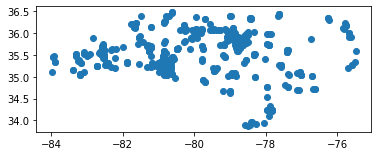

In [7]:
#Plot the data
gdf_stations_all.plot();

---
### Import and explore the census tract data for NC

In [28]:
#Build the data query (we'll discuss this later)
url_nconemap = 'https://services.nconemap.gov/secure/rest/services/'
svc_query = 'NC1Map_Census/FeatureServer/9/query?where=GEOID10>0&outFields=*&f=geojson'
url_data = url_nconemap+svc_query
print(url_data)

https://services.nconemap.gov/secure/rest/services/NC1Map_Census/FeatureServer/9/query?where=GEOID10>0&outFields=*&f=geojson


In [29]:
gdf_Tracts = gpd.read_file(url_data)
gdf_Tracts.shape

DriverError: '/vsimem/22c9a7d102b1434783327954fb6d95a4' not recognized as a supported file format.

In [14]:
#Pull the returned data into a geodataframe
gdf_Gages = gpd.read_file(url_data)
gdf_Gages.shape

(433, 13)

In [18]:
gdf_Gages.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
gdf_Gages.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    433 non-null    int64   
 1   SITE_NAME   433 non-null    object  
 2   TELEMETRY   433 non-null    object  
 3   STREAM_FLO  433 non-null    object  
 4   STAGE_ONLY  433 non-null    object  
 5   QW_SAMPLES  433 non-null    object  
 6   WQ_MONITOR  433 non-null    object  
 7   RAINFALL    433 non-null    object  
 8   MET         433 non-null    object  
 9   OFFICE      433 non-null    object  
 10  HUCODE      433 non-null    object  
 11  COUNTY      433 non-null    object  
 12  geometry    433 non-null    geometry
dtypes: geometry(1), int64(1), object(11)
memory usage: 44.1+ KB


<AxesSubplot:>

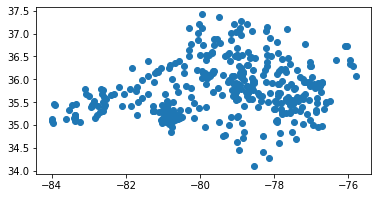

In [15]:
gdf_Gages.plot()

#### Step 4. Begin the analysis


In [ ]:
#List unique values in the City field
gdf_stations_all['City'].unique()

In [ ]:
#Subset records near Durham, Raleigh, Cary, and Chapel Hill
gdf_stations = gdf_stations_all.query('City in ("Durham","Raleigh","Cary","Chapel Hill")')
#Plot the results
gdf_stations.plot("City");

In [ ]:
#Plot them with a base map
fig, ax = plt.subplots(figsize = (10,5))
gdf_stations.to_crs(3857).plot(ax=ax, column="City")
ctx.add_basemap(ax)

* Buffer the points. 
 * To do this, first we need to project the data to a crs that uses meters: UTM Zone 17N. To find the EPSG number associated with this crs, navigate to https://epsg.org and search for `UTM Zone 17 N`. In the results, find the entry associated with WGS84, and record its epsg number. (It should be 32617.)

In [ ]:
#Transform stations to UTM Zone 17N 
gdf_stations_utm = gdf_stations.to_crs(32617)
print(gdf_stations_utm.crs)

In [ ]:
#Buffer the selected exits 2.5 km
gdf_stations_buffer = gdf_stations_utm.buffer(2500)
gdf_stations_buffer.plot(alpha=0.2);

Now we are going to fetch a dataset of NC Census Tracts. We'll use a Census web service that allows us to fetch data from an online query in GeoJSON format. 

In [ ]:
#Get Census Tracts
query_url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2019/Tracts_Blocks/MapServer/3/query?where=State+%3D+37&outFields=*&f=geojson'
gdf_Tracts = gpd.read_file(query_url)
#Show the shape of the returned dataframe
gdf_Tracts.shape

In [ ]:
gdf_Tracts.info()

In [ ]:
print(gdf_Tracts.crs)

In [ ]:
#plot points on tracts
ax = gdf_Tracts.plot('COUNTY',figsize=(12,6))
gdf_stations.plot(ax=ax,markersize=10,color="black");

In [ ]:
#Dissolve Tracts on Counties
gdf_Counties = gdf_Tracts.dissolve(by='COUNTY',aggfunc={'AREALAND':'sum'})
gdf_Counties.head()

In [ ]:
#plot points on tracts
ax = gdf_Counties.plot('AREALAND',figsize=(12,6))
gdf_stations.plot(ax=ax,markersize=10,color="black");